# Predicting Titanic Survivors with Classification Trees

#### Mathias Lund Ahrn

_This week I want you to produce a report (written as a Jupyter notebook) on predicting whether a passenger would survive the Titanic using classification trees._

_Below I give suggestions on the structure of your report, ideas on things you can include, and a little code. My comments are in italics – you should remove them from your report._

_In your Jupyter notebook you should show all of your R code._

_Have fun – pretend you are a consultant and were hired to do this as a small job._

## Introduction
_Include a few sentences here describing what you will do.  Include a short description of the data set._

In 1912 on April 15th the world witnessed a fatal tragedy, the unsinkable ship Titanic hit a iceberg which led to complete wreckage of the ship. Of all the 2224 people that were onboard, only 710 survived.

In this report we will be looking for any pattern(s) or group(s) of people/segments that either were more likely to survive or die.

##### Meta
- 1309 rows, each represents a person
- 12 features
 - PassengerId
 - Survived
 - Pclass
 - Name
 - Sex
 - Age
 - SibSp
 - Parch
 - Ticket
 - Fare
 - Cabin
 - Embarked


Feature | Desription | Notes
------ | ------ | ------
PassengerId || 
Survived |Survival| 0=no, 1=yes
Pclass |Ticket class| 1=1st, 2=2nd, 3=3rd
Name |Full name|
Sex |Gender|
Age ||
SibSp ||
Parch ||
Ticket ||
Fare ||
Cabin ||
Embarked || C = Cherbourg, Q = Queenstown, S = Southampton

### What to explore

- Ratio of survival based on Ticket Class. Is it higher chance for people with better economoy to survive? Could the reasoning be that higher classed tickets are at a higher level in the ship which leads to a longer timeframe to understand the situation and handle it accordingly?

- Percentage survivors for each Ticket Class from each port of embarkation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns        
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## Reading and preprocessing the data

_I'm including preprocessing code so you don't need to spend time on it.  There are interesting choices to be made in preprocessing this data.  One of the main concerns in the preprocessing to eliminate categorical columns that have many values.  If these columns were directly converted into numeric data using dummy variables there would be many columns added, and most of them would not be useful.  For example, the 'Cabin' column contains column numbers, and almost every value in the column is complete.  However, most cabin numbers start with one of a few capital letters, and it appears these letters may be significant._

In [2]:
input_file = "https://raw.githubusercontent.com/grbruns/cst383/master/titanic.csv"
df = pd.read_csv(input_file)

print(df.shape)
print(df.columns)
print((df[df["Age"] < 1])["Age"].value_counts())
# column PassengerId
# a unique numeric passenger ID; not needed
df.drop('PassengerId', axis=1, inplace=True)

# column Cabin
# use only first letter of Cabin
df['Cabin'] = df['Cabin'].str.slice(stop=1)
df['Cabin'].fillna('U', inplace=True)

# column Ticket
# use two categories: tickets containing letters and
# tickets containing only digits
df['Ticket'] = df['Ticket'].str.contains('[a-zA-Z]')

# column Embarked
# hardly any NA embarked values, so drop rows containing them
df.dropna(subset=['Embarked'], inplace=True)

# column Name
# retain only the title of the name, if present
def extract_title(s):
    titles = ['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Dr.']
    for title in titles:
        if title in s:
            return title
    return 'NoTitle'

df['Title'] = df['Name'].apply(extract_title)
df.drop('Name', axis=1, inplace=True)

# column Age
# fill with median value
df['Age'].fillna(df['Age'].median(), inplace=True)

# confirm that no NA values remain
df.isna().mean()
df.info()

(1309, 12)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
0.00    283
0.83      2
0.75      2
0.67      1
0.92      1
0.42      1
Name: Age, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
Survived    889 non-null int64
Pclass      889 non-null object
Sex         889 non-null object
Age         889 non-null float64
SibSp       889 non-null int64
Parch       889 non-null object
Ticket      889 non-null object
Fare        889 non-null object
Cabin       889 non-null object
Embarked    889 non-null object
Title       889 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 83.3+ KB


## Data exploration

_For data exploration I want you to produce at least a few interesting or relevant plots.  Use your curiousity and think about the columns that may be related to whether someone survived the sinking.  Do not include lengthy text output in your report._

#### How many people died/survived depending on the port they embarked from?

<class 'list'>
Southampton


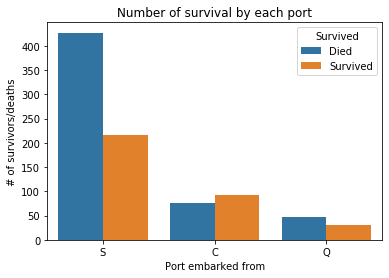

In [209]:
surv_plot = sns.countplot(data=df, x="Embarked", hue="Survived")
#surv_plot.set_xticklabels(["Southhampton", "Cherbourg", "Queensland"])
ports = ["Southampton", "Cherbourg", "Queensland"]
org_labels = surv_plot.get_xticklabels()
print(type(ports))
#for i in range(len(ports)):
 #   if(p[i], j in range(len(ports) == org_labels[j].get_text()):
 #      print("Hei")
#print(org_labels[i].get_text())

new_labels = [(p, l) for p in ports for l in org_labels if l.get_text() == p[0]]
print(new_labels[0][0])

#surv_plot.set_xticklabels(new_labels)

#for label in surv_plot.get_xticklabels():
   # if(label.get_text() == (ports[0][0])):
    #    surv_plot.set_xticklabels(ports[0][0])

#print(surv_plot.get_xticklabels()[0].get_text())
plt.title("Number of survival by each port")
plt.xlabel("Port embarked from")
plt.ylabel("# of survivors/deaths")
plt.legend(title="Survived", labels=["Died", "Survived"])
plt.show()


#### What is the ratio of survival depending on the port they embarked from?

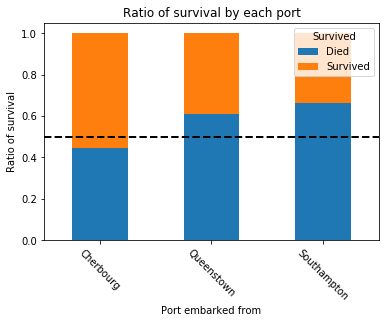

In [102]:
def calcSurvival(x):
    return x.groupby("Survived").size()/x["Embarked"].shape[0]


embar_surv = pd.DataFrame(df.groupby("Embarked").apply(calcSurvival))
embar_surv.rename({0:'Died', 1:'Survived'}, axis='columns', inplace=True)
ports = ["Cherbourg", "Queenstown", "Southampton"]
ax = embar_surv.plot.bar(stacked=True);
ax.set_xticklabels([port for port in ports], rotation=-45)
ax.set_title("Ratio of survival by each port")
ax.set_xlabel("Port embarked from")
ax.set_ylabel("Ratio of survival")
ax.axhline(y=0.5, xmin=0, xmax=1, color='black', linestyle='--', lw=2)
plt.show()

## Building a classification tree

_In this section you should get your data ready for use with Scikit-Learn by converting categorical variables to numeric variables.  Next you should convert your data to NumPy and then split the data into training and test sets.  Build a classification tree, and produce a plot of the fitted tree._

_Do not modify the seed below, which is included for repeatability._

In [5]:
np.random.seed(123)

## Making predictions and assessing your model

_In this section you should produce predictions from the test data. Next you will assess your results.  Minimally you will report your accuracy (success rate), and present a confusion matrix.  Don't forget to compare your accuracy to a baseline accuracy._

_Make your own choices about what other diagnostic plots to report._

_Note that DecisionTreeClassifier can be used to predict either class labels or probabilities. You can try getting probabilities, and then using some of the diagnostic plots we used with logistic regression. However, I’ve found that some of the plots used with logistic regression, such as ROC plots, don’t work well with rpart._

_I would like you to produce a learning curve to try to see if high bias or high variance is a problem. You should use this information in deciding what to do next. (See the System Design lab for code helpful in creating a learning curve.)_

## Model 2

_Based on what you learned above, you will probably want to build one or more additional models. You should assess additional models similarly to how you assessed your first one._

_Some other things you can try include: improving your model by setting the hyperparameters of the decision tree, using grid search with cross validation, and looking at feature importance._

## Conclusions

_Say a little here about your results.  For example, which predictors were most useful?  How good were your predictions compared to the baseline?_